C:\Users\mhfar\AppData\Local\Temp\ipykernel_8160\1299227890.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab10")


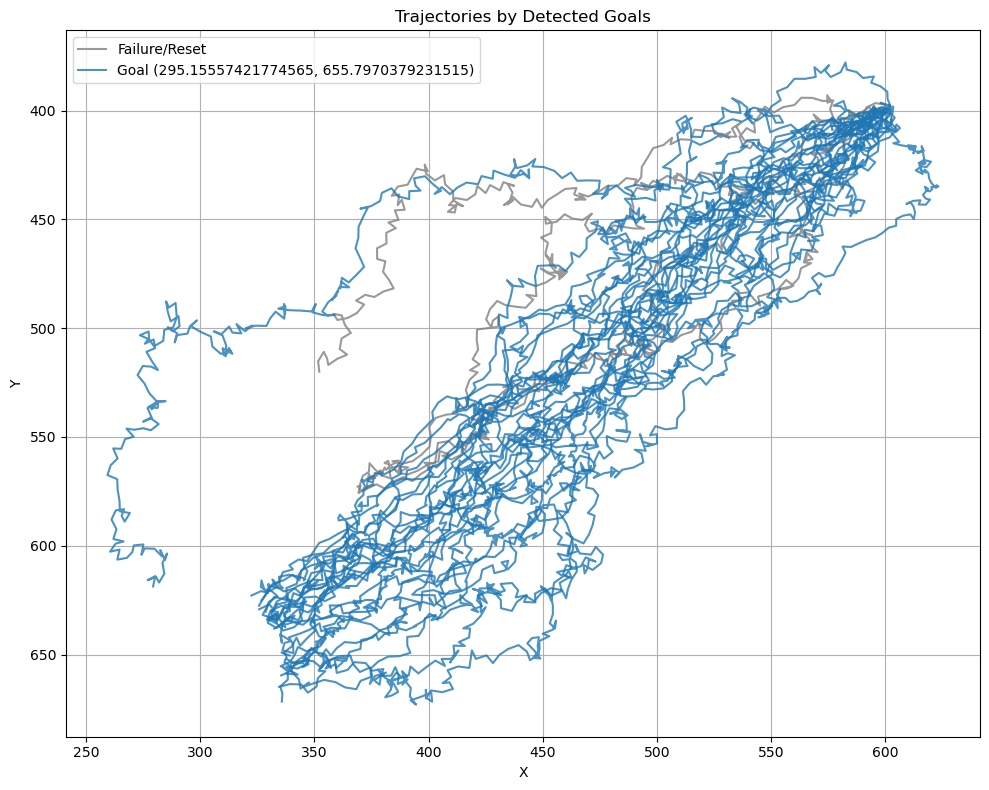

===== Fitts’ Law Metrics (Throughput) by Mode =====
Mode=Manual   | Avg Throughput=0.683 bits/s
Mode=AI       | Avg Throughput=0.906 bits/s


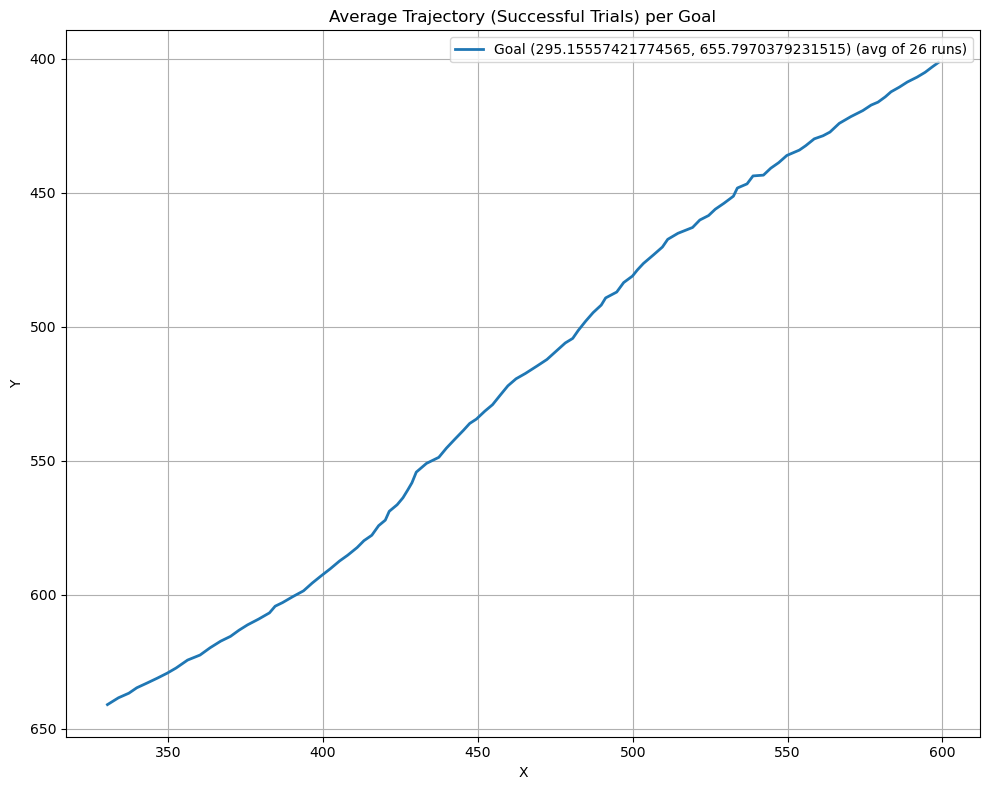

In [3]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import math

###############################################################################
# 1. LOAD DATA
###############################################################################
file_path = r"C:\Users\mhfar\OneDrive\Desktop\Depo\Code\Cursor\End-Effector-Test-Environment\End-Effector-Test-Environment\user study data\data_log_20250224_203942.json"
if not os.path.exists(file_path):
    print(f"File not found: {file_path}")
    exit()

with open(file_path, "r") as f:
    data_log = json.load(f)

if not data_log:
    print("No trials found in data_log.")
    exit()

###############################################################################
# 2. GATHER UNIQUE GOALS & ASSIGN COLORS
###############################################################################
unique_goals = set()
for trial in data_log:
    goal = trial.get("goal_reached")
    if goal is not None:
        unique_goals.add(tuple(goal))  # convert list->tuple for hashing
unique_goals = sorted(list(unique_goals))  # consistent ordering

cmap = plt.cm.get_cmap("tab10")
goal_colors = {}
for i, g in enumerate(unique_goals):
    color = cmap(i % 10)
    goal_colors[g] = color

###############################################################################
# 3. PLOT RAW TRAJECTORIES
###############################################################################
plt.figure(figsize=(10, 8))
used_labels = set()

for trial in data_log:
    trajectory = trial.get("trajectory", [])
    if not trajectory:
        continue

    xs = [pt[0] for pt in trajectory]
    ys = [pt[1] for pt in trajectory]

    outcome = trial.get("trial_outcome")
    goal = trial.get("goal_reached")

    if outcome == "success" and goal is not None:
        goal_tuple = tuple(goal)
        line_color = goal_colors.get(goal_tuple, "black")
        label_text = f"Goal {goal_tuple}"
    else:
        line_color = "grey"
        label_text = "Failure/Reset"

    # Add each label only once
    label = label_text if label_text not in used_labels else None
    used_labels.add(label_text)

    plt.plot(xs, ys, color=line_color, linewidth=1.5, alpha=0.8, label=label)

plt.xlabel("X")
plt.ylabel("Y")
plt.title("Trajectories by Detected Goals")
plt.gca().invert_yaxis()  # Optional: invert if your screen coords go top->down
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

###############################################################################
# 4. COMPUTE QUALITY METRICS (Fitts’-like)
###############################################################################
# Some environment measure for "target width" (in pixels).
# Adjust to match your actual environment’s “effective width.”
# E.g., if DOT_RADIUS=15 and TARGET_RADIUS=10, a naive choice might be 2*(15+10)=50.
target_width = 50.0  

# We'll store metrics in a list of dicts
fitts_metrics = []
for trial in data_log:
    outcome = trial.get("trial_outcome")
    if outcome != "success":
        continue  # We only compute Fitts’ metrics for successful trials
    traj = trial.get("trajectory", [])
    if len(traj) < 2:
        continue
    # Movement time
    T = trial.get("trial_duration", None)
    if T is None or T <= 0:
        continue

    # Distance from first to last point (or to the goal)
    start_x, start_y = traj[0]
    end_x, end_y = traj[-1]
    # Alternatively, you could do distance to trial["goal_reached"]
    # if you prefer that as the final location
    D = math.hypot(end_x - start_x, end_y - start_y)

    # Compute index of difficulty (ID): log2(D/W + 1)
    # If D < W, ID can be zero or negative; clamp or handle carefully.
    # Also watch out for D=0 corner cases.
    if D < 1e-9:
        continue
    ID = math.log2(D / target_width + 1.0)

    # Throughput (bits/s) = ID / time
    # If ID is negative (D < W/2?), throughput is somewhat ill-defined.
    # We'll proceed but be aware of edge cases.
    throughput = ID / T if T > 0 else float('nan')

    fitts_metrics.append({
        "mode": trial.get("mode", "Unknown"),   # e.g. "Manual" or "AI"
        "goal_reached": trial.get("goal_reached"),
        "distance": D,
        "time": T,
        "ID": ID,
        "throughput": throughput
    })

# For demonstration, let’s print the average throughput by mode:
if fitts_metrics:
    metrics_by_mode = {}
    for fm in fitts_metrics:
        mode = fm["mode"]
        if mode not in metrics_by_mode:
            metrics_by_mode[mode] = []
        metrics_by_mode[mode].append(fm["throughput"])
    
    print("===== Fitts’ Law Metrics (Throughput) by Mode =====")
    for mode, throughputs in metrics_by_mode.items():
        avg_tput = np.mean(throughputs)
        print(f"Mode={mode:8s} | Avg Throughput={avg_tput:.3f} bits/s")

###############################################################################
# 5. AVERAGE TRAJECTORIES FOR EACH GOAL
###############################################################################
def resample_trajectory(traj, num_samples=100):
    """
    Resample a trajectory (list of (x,y)) into `num_samples` points
    evenly spaced in terms of *index* (not time).
    If you had actual timestamps, you could do time interpolation instead.
    """
    if len(traj) < 2:
        # not enough points to resample
        return traj
    
    # Convert to numpy for convenience
    traj_np = np.array(traj)  # shape (N,2)
    original_len = len(traj_np)
    # We'll create new indices from 0..(original_len-1)
    original_indices = np.linspace(0, original_len-1, original_len)
    target_indices   = np.linspace(0, original_len-1, num_samples)
    
    # Interpolate x and y separately
    xs = np.interp(target_indices, original_indices, traj_np[:, 0])
    ys = np.interp(target_indices, original_indices, traj_np[:, 1])
    return np.column_stack((xs, ys))

# Gather all (successful) trajectories by goal
goal_trajs = {g: [] for g in unique_goals}

for trial in data_log:
    outcome = trial.get("trial_outcome")
    if outcome != "success":
        continue
    goal = trial.get("goal_reached")
    if goal is None:
        continue
    goal = tuple(goal)
    traj = trial.get("trajectory", [])
    if not traj:
        continue
    # Resample the trajectory to a fixed length for averaging
    rs_traj = resample_trajectory(traj, num_samples=100)
    goal_trajs[goal].append(rs_traj)

# Compute average path for each goal
avg_paths = {}
for g, list_of_trajs in goal_trajs.items():
    if not list_of_trajs:
        continue
    # Stack them: shape (#trials, #samples, 2)
    all_np = np.stack(list_of_trajs, axis=0)
    # Average across the first dimension (the trials)
    mean_traj = np.mean(all_np, axis=0)  # shape (100,2)
    avg_paths[g] = mean_traj

###############################################################################
# 6. PLOT AVERAGE TRAJECTORIES
###############################################################################
plt.figure(figsize=(10, 8))
for g, mean_traj in avg_paths.items():
    plt.plot(mean_traj[:, 0], mean_traj[:, 1],
             color=goal_colors[g], linewidth=2,
             label=f"Goal {g} (avg of {len(goal_trajs[g])} runs)")

plt.xlabel("X")
plt.ylabel("Y")
plt.title("Average Trajectory (Successful Trials) per Goal")
plt.gca().invert_yaxis()
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
